--- WiDiD: Incremental Word Sense Discovery for Parliamentary Speeches ---
Term 27, Year 1–2

In [1]:
# ## Imports 
%pip install "elasticsearch==8.6.2" sentence-transformers scikit-learn pandas matplotlib
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/wbagger/Documents/Semantic-Analysis-of-TBMM-Transcripts/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ## Configuration
INDEX_NAME = "parliament_speeches"
ES_URL = "http://localhost:9200"   # adjust if different
TERM_YEAR_TUPLES = [(27, 2), (27, 3)]  # (term, year) pairs processed sequentially
TARGET_WORDS = ["katar", "salça", "doğalgaz", "afrika", "anne"]  # add more words if needed
BASELINE_MAX_CLUSTERS = 50  # cap for the first (term, year)
MAX_CLUSTERS = 100          # cap for the remaining (term, year) slices
SIMILARITY_THRESHOLD = 0.8  # cosine similarity needed to reuse a cluster color
OUTPUT_DIR = "./widid_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
# ## Connect to Elasticsearch
es = Elasticsearch(ES_URL)
print("Connected to Elasticsearch ")
print(es.info().body["version"]["number"])

Connected to Elasticsearch 
8.6.1


## Helper Functions

In [6]:
def fetch_speeches(term, year, size=10000):
    """Fetch speeches for a specific term and year."""
    query = {
        "size": size,
        "_source": ["content", "term", "year"],
        "query": {
            "bool": {
                "must": [
                    {"term": {"term": term}},
                    {"term": {"year": year}}
                ]
            }
        }
    }
    res = es.search(index=INDEX_NAME, body=query)
    return [hit["_source"]["content"] for hit in res["hits"]["hits"]]

In [ ]:
def extract_contexts(texts, target_word, window=10):
    """Extract short context windows around target word and its morphological variations."""
    contexts = []
    # Create regex pattern to match target word and any Turkish suffixes
    pattern = re.compile(rf"\b{re.escape(target_word.lower())}\w*\b")
    
    for t in texts:
        tokens = re.findall(r"\w+", t.lower()) # simple tokenization, one or more word characters 
        for i, tok in enumerate(tokens):
            # Use regex to match the word and its variations
            if pattern.match(tok):
                start = max(0, i - window)
                end = min(len(tokens), i + window + 1)
                snippet = " ".join(tokens[start:end])
                contexts.append(snippet)
    return contexts

In [8]:
def compute_embeddings(model, contexts):
    """Compute embeddings for context snippets."""
    if len(contexts) == 0:
        return np.empty((0, model.get_sentence_embedding_dimension()))
    return model.encode(contexts, show_progress_bar=True)

In [ ]:
def get_cluster_prototypes(X, labels, return_label_ids=False):
    """Compute centroids for each cluster and optionally return their IDs."""
    clusters = []
    label_ids = []
    for label in np.unique(labels):
        if label == -1:
            continue
        members = X[labels == label]
        if len(members) == 0:
            continue
        centroid = np.mean(members, axis=0)
        clusters.append(centroid)
        label_ids.append(label)
    clusters = np.array(clusters)
    if return_label_ids:
        return clusters, label_ids
    return clusters

In [ ]:
def show_top_contexts(contexts, labels, n=3):
    """Print representative contexts for each cluster."""
    df = pd.DataFrame({"cluster": labels, "context": contexts})
    grouped = df.groupby("cluster")["context"].apply(list)
    for cluster, examples in grouped.items():
        cluster_name = "overflow/filtered" if cluster == -1 else cluster
        print(f"\n🌀 Cluster {cluster_name} ({len(examples)} examples):")
        for ex in examples[:n]:
            print("   •", ex[:200].replace("\n", " ") + ("..." if len(ex) > 200 else ""))

In [ ]:
def limit_clusters(labels, max_clusters):
    """Keep only the largest max_clusters and map the rest to -1."""
    if max_clusters is None:
        return labels, np.unique(labels).tolist()
    labels = np.asarray(labels)
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = [
        (label, count) for label, count in zip(unique, counts) if label != -1
    ]
    cluster_counts.sort(key=lambda item: item[1], reverse=True)
    keep = [label for label, _ in cluster_counts[:max_clusters]]
    if not keep:
        return np.full_like(labels, -1), []
    filtered = np.array([label if label in keep else -1 for label in labels], dtype=labels.dtype)
    return filtered, keep


class ClusterAligner:
    """Keeps global cluster IDs and assigns consistent colors over time."""

    def __init__(self, max_clusters=100, similarity_threshold=0.8, cmap_name="gist_ncar"):
        self.max_clusters = max_clusters
        self.similarity_threshold = similarity_threshold
        self.centroids = []
        self.global_ids = []
        self.cmap = plt.cm.get_cmap(cmap_name, max_clusters)
        self.palette = [self.cmap(i) for i in range(self.cmap.N)]
        self.overflow_color = (0.65, 0.65, 0.65, 1.0)

    def _add_centroid(self, centroid):
        if len(self.global_ids) >= self.max_clusters:
            return -1
        new_id = len(self.global_ids)
        self.centroids.append(centroid)
        self.global_ids.append(new_id)
        return new_id

    def _match_or_create(self, centroid):
        centroid = centroid.reshape(1, -1)
        if not self.centroids:
            return self._add_centroid(centroid)
        stacked = np.vstack(self.centroids)
        sims = cosine_similarity(stacked, centroid)[:, 0]
        best_idx = int(np.argmax(sims))
        if sims[best_idx] >= self.similarity_threshold:
            return self.global_ids[best_idx]
        return self._add_centroid(centroid)

    def align(self, raw_labels, centroid_map):
        aligned = np.full_like(raw_labels, -1)
        for local_label, centroid in centroid_map.items():
            global_id = self._match_or_create(centroid)
            if global_id == -1:
                continue
            aligned[raw_labels == local_label] = global_id
        return aligned

    def colors_for(self, labels):
        return [
            self.palette[label]
            if 0 <= label < len(self.palette)
            else self.overflow_color
            for label in labels
        ]


def plot_tsne(term, year, word, embeddings, aligned_labels, aligner):
    if len(embeddings) < 2:
        print("  Skipping t-SNE (insufficient embeddings).")
        return
    desired = max(5, len(embeddings) // 3)
    max_valid = max(1, len(embeddings) - 1)
    perplexity = min(desired, max_valid, 30)
    tsne_coords = TSNE(n_components=2, random_state=42, perplexity=perplexity).fit_transform(embeddings)
    colors = aligner.colors_for(aligned_labels)
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], c=colors, alpha=0.8, edgecolors="none")
    plt.title(f"'{word}' Term {term} Year {year} (t-SNE)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    tsne_path = os.path.join(OUTPUT_DIR, f"tsne_term{term}_year{year}_{word}.png")
    plt.savefig(tsne_path, bbox_inches="tight")
    plt.show()
    print(f"  Saved t-SNE plot to {tsne_path}")


In [ ]:
def create_cluster_guide(cluster_contexts_map, target_word, output_dir, aligner):
    """
    Create a cluster guide with summary CSV and detailed context file.
    Shows what each global cluster represents semantically.
    """
    
    if not cluster_contexts_map:
        print("  No clusters to document.")
        return
    
    # Calculate statistics for each cluster
    guide_rows = []
    for global_id in sorted(cluster_contexts_map.keys()):
        contexts = cluster_contexts_map[global_id]
        term_years = sorted(set(f"T{ctx['term']}Y{ctx['year']}" for ctx in contexts))
        
        guide_rows.append({
            'global_id': global_id,
            'color_index': global_id,
            'total_contexts': len(contexts),
            'term_year_span': ', '.join(term_years),
            'num_appearances': len(term_years)
        })
    
    # Create summary CSV
    df_summary = pd.DataFrame(guide_rows).sort_values('total_contexts', ascending=False)
    summary_path = os.path.join(output_dir, f"cluster_guide_{target_word}_summary.csv")
    df_summary.to_csv(summary_path, index=False)
    print(f"  Saved cluster summary to {summary_path}")
    
    # Create detailed context file
    context_file_path = os.path.join(output_dir, f"cluster_guide_{target_word}_contexts.txt")
    with open(context_file_path, 'w', encoding='utf-8') as f:
        f.write(f"{'='*80}\n")
        f.write(f"CLUSTER GUIDE FOR '{target_word.upper()}'\n")
        f.write(f"Generated: {pd.Timestamp.now()}\n")
        f.write(f"Total clusters: {len(cluster_contexts_map)}\n")
        f.write(f"{'='*80}\n\n")
        
        # Sort clusters by total contexts (most common first)
        for global_id in sorted(cluster_contexts_map.keys(), 
                               key=lambda x: len(cluster_contexts_map[x]), 
                               reverse=True):
            contexts = cluster_contexts_map[global_id]
            term_years = sorted(set(f"T{ctx['term']}Y{ctx['year']}" for ctx in contexts))
            
            # Get color info
            color = aligner.get_color(global_id)
            color_hex = '#{:02x}{:02x}{:02x}'.format(
                int(color[0]*255), int(color[1]*255), int(color[2]*255)
            )
            
            f.write(f"\n{'='*80}\n")
            f.write(f"CLUSTER {global_id} (Color: {color_hex})\n")
            f.write(f"{'-'*80}\n")
            f.write(f"Total contexts: {len(contexts)}\n")
            f.write(f"Appearances: {len(term_years)} term-years\n")
            f.write(f"Term-year span: {', '.join(term_years)}\n")
            f.write(f"\nREPRESENTATIVE CONTEXTS:\n")
            f.write(f"{'-'*80}\n")
            
            # Show up to 15 diverse examples
            shown = 0
            for ctx_item in contexts[:15]:
                f.write(f"\n[{ctx_item['term']}-{ctx_item['year']}] ")
                f.write(ctx_item['context'][:250])
                if len(ctx_item['context']) > 250:
                    f.write("...")
                f.write("\n")
                shown += 1
            
            if len(contexts) > 15:
                f.write(f"\n... and {len(contexts) - 15} more contexts\n")
    
    print(f"  Saved detailed contexts to {context_file_path}")
    print(f"  Total clusters documented: {len(cluster_contexts_map)}")
    
    return df_summary


In [11]:
# ## Load Sentence Transformer Model
model = SentenceTransformer("all-MiniLM-L6-v2") 
print("Model loaded ")

Model loaded 


## 6️⃣ Main Loop Over Words



===  Analyzing 'katar' (Term 27) ===


/var/folders/z8/s1r54khs3b3g5pz151jsffdr0000gn/T/ipykernel_37249/291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


Contexts Year1: 39, Year2: 137


Batches: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


 Year 1 clusters: 8
 Year 2 clusters: 12

=== Year 1 Clusters ===

🌀 Cluster 0 (1 examples):
   • dünkü toplantısında cumhurbaşkanı yardımcısı sayın fuat oktay cumhurbaşkanının binmesi için katar dan alınan uçan sarayla ilgili sorulara hem cevap vermiş hem

🌀 Cluster 1 (2 examples):
   • ithal ediyoruz rusya azerbaycan i ran ve lng olarak cezayir katar nijerya gibi ülkelerden 8 10 çeşit kaynak ülkenin ürünlerini burada
   • amerika görüşüyor rusya görüşüyor i ran görüşüyor suudi arabistan görüşüyor katar görüşüyor ama siz görüşmüyorsunuz neden çünkü öyle bir angajmana girdiniz

🌀 Cluster 2 (3 examples):
   • gaz aramalarına ses çıkaracak kadar dahi gücünüz yok sizin bu katar a bağlılığınız sessizliğiniz nereden geliyor siz hangi cüretle tank palet
   • bağlılığınız sessizliğiniz nereden geliyor siz hangi cüretle tank palet fabrikasını katar a peşkeş çekiyorsunuz hangi cüretle hangi bedeller karşılığında yeşil dolarlar
   • ve kendi özüne güvenmeyen bir anlayış bugün tank palet fabrikas

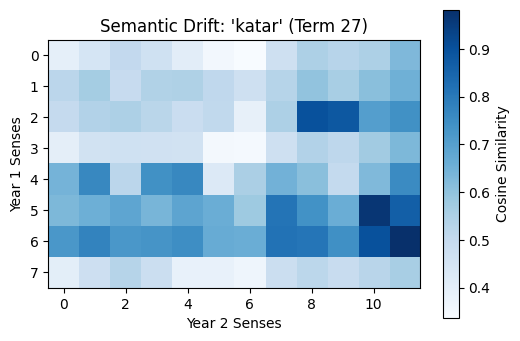

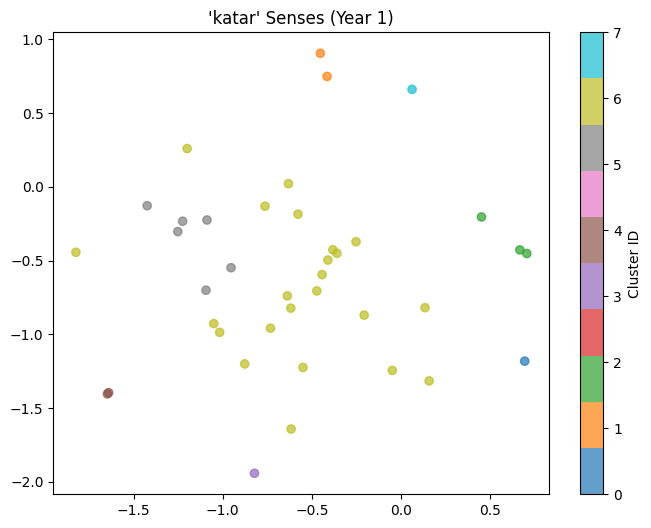

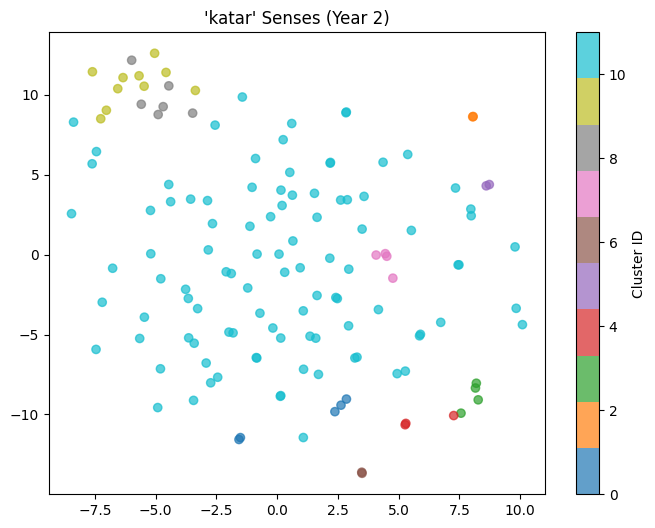

✅ Visualizations saved for 'katar'
-----------------------------------------------------


===  Analyzing 'salça' (Term 27) ===


/var/folders/z8/s1r54khs3b3g5pz151jsffdr0000gn/T/ipykernel_37249/291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


Contexts Year1: 3, Year2: 2
 Not enough contexts for one of the years, skipping...


===  Analyzing 'doğalgaz' (Term 27) ===
Contexts Year1: 3, Year2: 7
 Not enough contexts for one of the years, skipping...


===  Analyzing 'afrika' (Term 27) ===
Contexts Year1: 45, Year2: 163


Batches: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


 Year 1 clusters: 7
 Year 2 clusters: 13

=== Year 1 Clusters ===

🌀 Cluster 0 (2 examples):
   • bu kapsamda 2018 yılında 21 ülkeyle 131 ikili görüşme gerçekleştirdik afrika yla ekonomik iş forumu gerçekleştirdik ve bunlardan ekim ayında gerçekleştirdiğimiz
   • ekonomik iş forumu gerçekleştirdik ve bunlardan ekim ayında gerçekleştirdiğimiz foruma afrika dan 27 ülke bakan ve bakan yardımcısı seviyesinde katılmış bulunmaktadır

🌀 Cluster 1 (5 examples):
   • desteklenen o örgütler bugün bütün dünyayı kana bulayan örgütlerdir bugün afrika da suriye de irak ta dünyanın dört bir yanını kanatan
   • gazetecilerin endeksinde 180 ülke var biz 157 nciyiz arkadaşlar yani afrika nın bazı ülkeleri kuzey kore suudi arabistan gibi ülkelerle aynı
   • değerli milletvekilleri dünya ülkeleri kendi kömüründen istifade ediyor hatta güney afrika kömürünün yüzde 90 ını kendisi çıkarıyor ve kendisi kullanıyor almanya

🌀 Cluster 2 (22 examples):
   • irak ın değil bütün bir orta doğu nun bütün bir afrika n

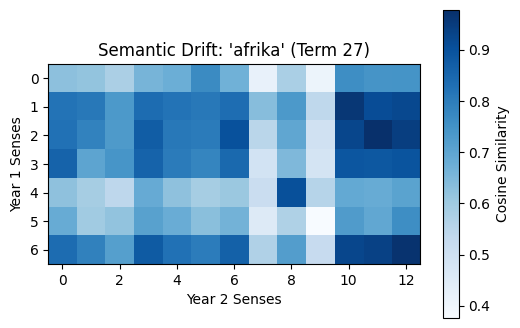

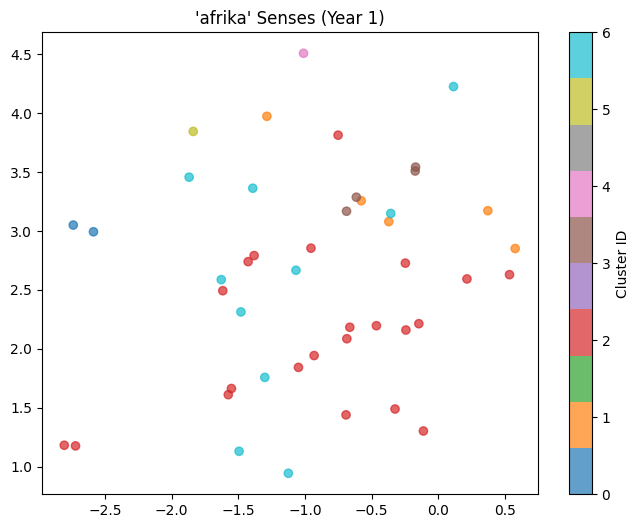

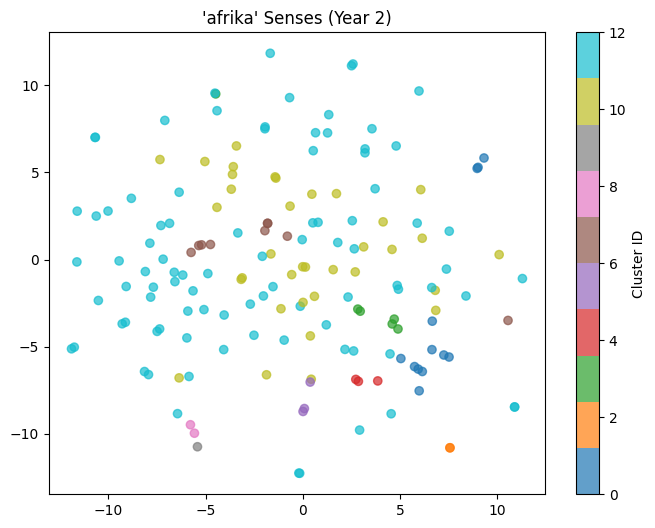

✅ Visualizations saved for 'afrika'
-----------------------------------------------------


===  Analyzing 'anne' (Term 27) ===


/var/folders/z8/s1r54khs3b3g5pz151jsffdr0000gn/T/ipykernel_37249/291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


Contexts Year1: 95, Year2: 132


Batches: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


 Year 1 clusters: 16
 Year 2 clusters: 10

=== Year 1 Clusters ===

🌀 Cluster 0 (14 examples):
   • namazı sırasında verdiği bilgiye göre bir hafta önce izne gelmiş anne ve babasını mezarlığa götürmüş ben şehit olursam beni buraya defnedin
   • hdp li seçmenlerimizin birinin evine baskın yapıldı polisler tarafından evde anne baba ve çocuk bulunuyor şöyle bir şey söylemiş polis üçünüzden
   • tam 72 bin kişi kim bilir ne umutlarla açtığı belki anne babasından kalan iş yerlerini kapatmak zorunda kaldı milyarlarca lira kobi

🌀 Cluster 1 (15 examples):
   • can gelin evladımız mardin deki saldırıda yaralanmıştı yoğun bakımdaydı ailesiyle anne ve babasıyla konuştuk kendisine buradan sağlık diliyorum geçmiş olsun dileklerimi
   • birlikte gayrettepe emniyet müdürlüğü siyasi şubeye götürüldü gayrettepe ye giden anne elmas eren hayrettin in gözaltına alınırken kullandığı otomobili siyasi şubenin
   • nın döşediği mayınların patlamasıyla yaşamını yitirdi terör örgütünü şiddetle lanetliyorum ann

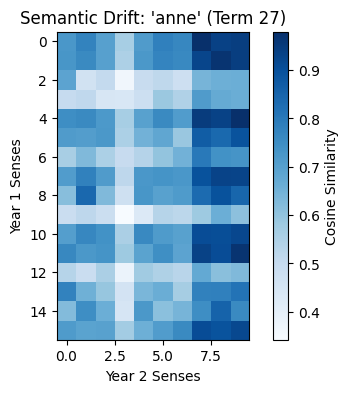

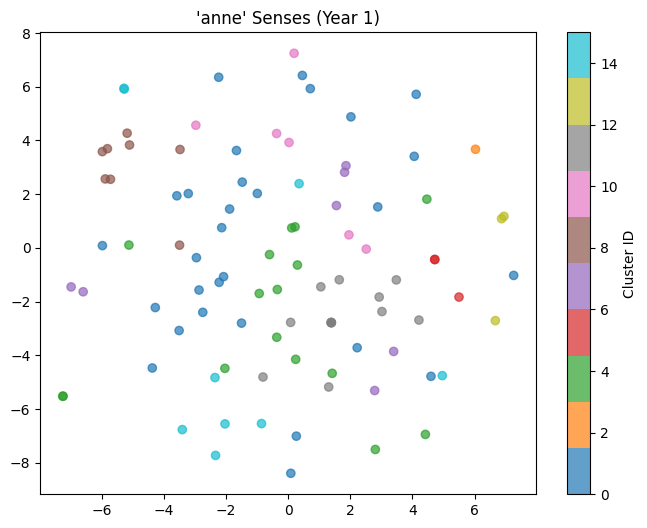

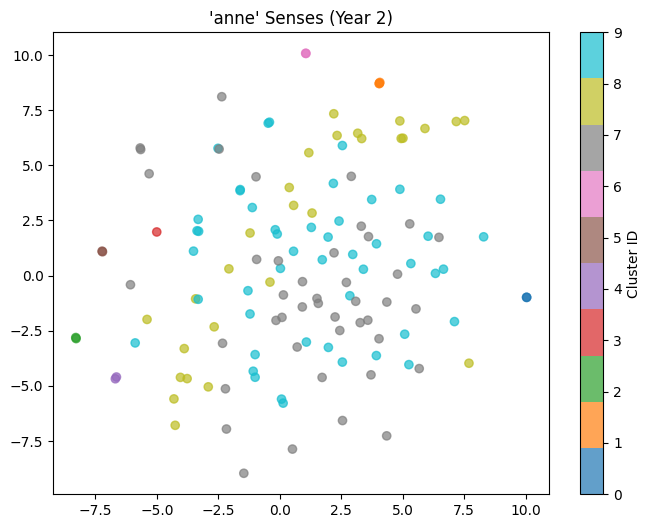

✅ Visualizations saved for 'anne'
-----------------------------------------------------


In [ ]:
for target_word in TARGET_WORDS:
    print(f"\n\n===  Analyzing '{target_word}' across {len(TERM_YEAR_TUPLES)} term-year pairs ===")
    aligner = ClusterAligner(max_clusters=MAX_CLUSTERS, similarity_threshold=SIMILARITY_THRESHOLD)
    baseline_used = False
    cluster_contexts_map = {}  # Store contexts per global_id for cluster guide

    for term, year in TERM_YEAR_TUPLES:
        print(f"\n--- Term {term}, Year {year} ---")
        texts = fetch_speeches(term, year)
        contexts = extract_contexts(texts, target_word)
        print(f"  Contexts: {len(contexts)}")
        if len(contexts) < 30:
            print("  Not enough contexts, skipping this slice.")
            continue

        embeddings = compute_embeddings(model, contexts)
        ap = AffinityPropagation(random_state=42)
        ap.fit(embeddings)
        local_labels = ap.labels_

        cap = BASELINE_MAX_CLUSTERS if not baseline_used else MAX_CLUSTERS
        limited_labels, kept_clusters = limit_clusters(local_labels, cap)
        print(f"  Raw clusters: {len(np.unique(local_labels))}, kept: {len(kept_clusters)} (cap={cap})")

        prototypes, proto_labels = get_cluster_prototypes(embeddings, limited_labels, return_label_ids=True)
        centroid_map = dict(zip(proto_labels, prototypes))
        if not centroid_map:
            print("  No clusters survived filtering, skipping visualization.")
            continue

        baseline_used = True
        aligned_labels = aligner.align(limited_labels, centroid_map)
        global_cluster_count = len(set(label for label in aligned_labels if label >= 0))
        print(f"  Global clusters represented: {global_cluster_count}")

        # Store context examples for cluster guide (up to 10 per global cluster per term-year)
        for global_id in set(label for label in aligned_labels if label >= 0):
            cluster_context_examples = [
                contexts[i] for i, label in enumerate(aligned_labels) if label == global_id
            ]
            if global_id not in cluster_contexts_map:
                cluster_contexts_map[global_id] = []
            cluster_contexts_map[global_id].extend([
                {'term': term, 'year': year, 'context': ctx} 
                for ctx in cluster_context_examples[:10]
            ])

        print("\n=== Representative Contexts ===")
        show_top_contexts(contexts, aligned_labels)

        df = pd.DataFrame(
            {
                "term": term,
                "year": year,
                "context": contexts,
                "local_cluster": limited_labels,
                "global_cluster": aligned_labels,
            }
        )
        csv_path = os.path.join(OUTPUT_DIR, f"widid_term{term}_year{year}_{target_word}.csv")
        df.to_csv(csv_path, index=False)
        print(f"  Saved clusters to {csv_path}")

        plot_tsne(term, year, target_word, embeddings, aligned_labels, aligner)

    # Generate cluster guide after processing all term-years for this word
    print("\n=== Generating Cluster Guide ===")
    create_cluster_guide(cluster_contexts_map, target_word, OUTPUT_DIR, aligner)
    print("-----------------------------------------------------")